In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sc
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from qlr import QuantileLinearRegression

import os

In [2]:
def elapsedtime_to_sec(el):
    tab = el.split(":")
    return float(tab[0])*60+float(tab[1])
#because x264 output is "m:s", where m is the number of minutes and s the number of seconds 

res_dir = "../../data/res_ugc/"

v_names = sorted(os.listdir(res_dir)) # so we keep the same ids between two launches

listVideo = []

for v in v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    assert data.shape == (201,36) or data.shape == (201,34), v
    listVideo.append(data)

In [3]:
#our variable of interest
predDimension = "size"

# RQ1 - Input sensitivity

## RQ1.1 - Do the same options have the same effect on all inputs?

In [4]:
nbVideos = len(listVideo)
corrSpearman= [[0 for x in range(nbVideos)] for y in range(nbVideos)]

for i in range(nbVideos):
    for j in range(nbVideos):
        if (i == j):
            corrSpearman[i][j] = 1
        else:
            corrSpearman[i][j] = sc.spearmanr(listVideo[i][predDimension],
                                            listVideo[j][predDimension]).correlation

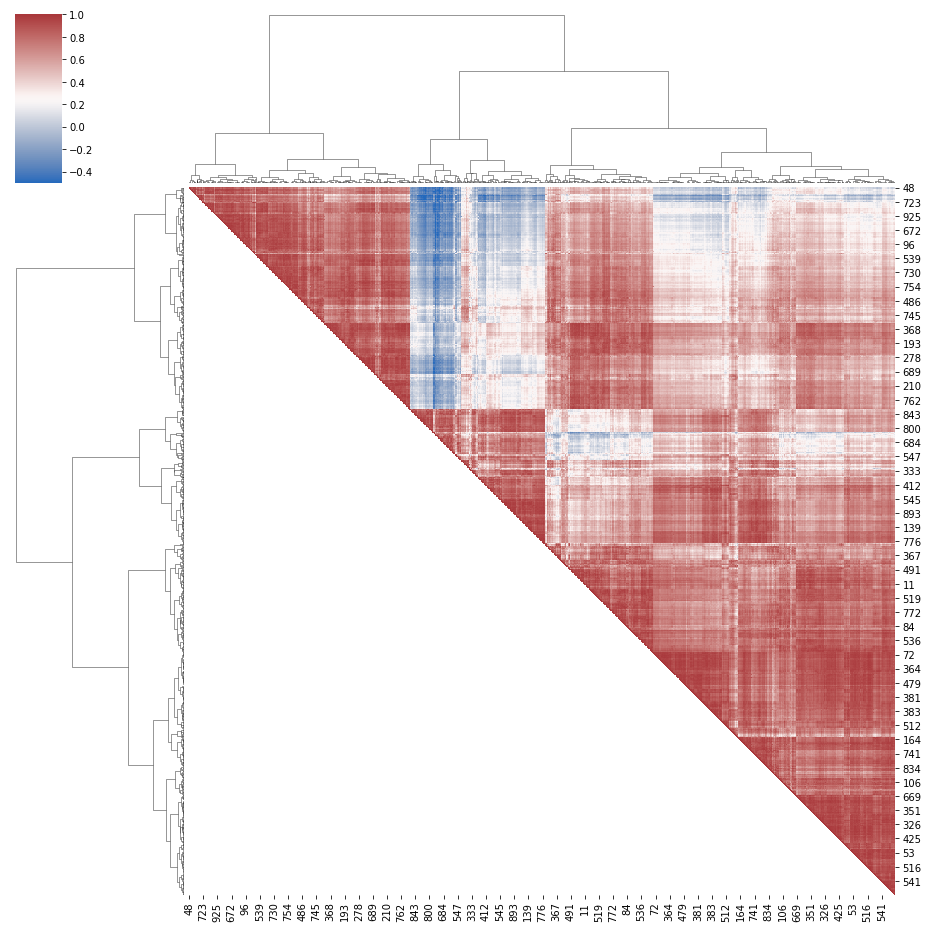

In [5]:
result_dir = "../../results/"

def plot_correlationmatrix_dendogram(corr, img_name, ticks, method= 'ward', div=False):

    df = pd.DataFrame(corr)
    
    # group the videos
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(nbVideos):
        for j in range(nbVideos):
            if i>j:
                mask[order[i]][order[j]] = True
    
    sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), cbar_kws={"ticks":ticks}, vmin =-0.5)
    plt.savefig(result_dir+img_name)
    plt.show()
    
    return cut_tree(links, n_clusters = 3)

group_no_ordered = plot_correlationmatrix_dendogram(corrSpearman, 
                                 "corrmatrix-ugc-dendo-Spearman-" + predDimension + ".pdf",
                                 [k/5 for k in np.arange(-10,10,1)], method='ward')

In [6]:
map_group = [1, 2, 0]

def f(gr):
    return map_group[int(gr)]

groups = np.array([*map(f, group_no_ordered)],int)

sum(groups==0)
sum(groups==1)
sum(groups==2)

471

In [7]:
corrDescription = [corrSpearman[i][j] for i in range(nbVideos) for j in range(nbVideos) if i >j]
pd.Series(corrDescription).describe()

count    450775.000000
mean          0.570571
std           0.288513
min          -0.693836
25%           0.401631
50%           0.635701
75%           0.797147
max           0.997228
dtype: float64

In [8]:
def plot_simple_correlationmatrix_dendogram(corr, img_name, ticks, id_names, method='ward'):

    df = pd.DataFrame(corr)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(shortnbVideos):
        for j in range(shortnbVideos):
            if i>j:
                mask[i][j] = True
    fig = plt.figure(figsize=(10, 8.5))
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(df, cmap="vlag", mask=mask,
               linewidths=.75, cbar_kws={"ticks":ticks})
    plt.yticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.xticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.savefig(result_dir+img_name)
    plt.show()

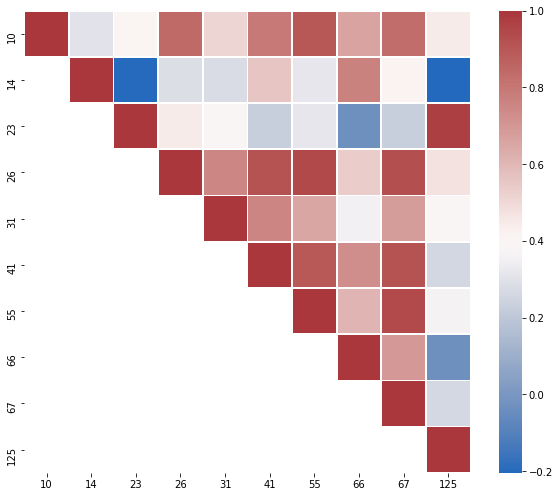

In [9]:
id_short = [10, 14, 23, 26, 31, 41, 55, 66, 67, 125]
short_v_names = [v_names[k] for k in id_short]

shortlistVideo = []
for v in short_v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    shortlistVideo.append(data)
    
shortnbVideos = len(shortlistVideo)

shortcorrSpearman= [[0 for x in range(shortnbVideos)] for y in range(shortnbVideos)]


for i in range(shortnbVideos):
    for j in range(shortnbVideos):
        if (i == j):
            shortcorrSpearman[i][j] = 1
        else:
            shortcorrSpearman[i][j] = sc.spearmanr(listVideo[id_short[i]][predDimension],listVideo[id_short[j]][predDimension]).correlation

plot_simple_correlationmatrix_dendogram(shortcorrSpearman, 
                     "../../results/corrmatrix-ugc-dendo-Spearman-short-" + predDimension + ".png", 
                     [k/5 for k in np.arange(-10,10,1)],
                                      id_short)

# RQ1-2

### Shortlist

In [10]:
id_short

[10, 14, 23, 26, 31, 41, 55, 66, 67, 125]

In [11]:
shortlistVideo[0] # video 10

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,usertime,systemtime,elapsedtime,cpu,frames,fps,kbs,ssim,ssimdb,etime
0,1,0,1,0:0:0,0:0,dia,0,0,16,0,...,8.69,0.92,0:01.75,549,480,379.18,7675.34,NaN,NaN,1.75
1,101,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,29.88,1.56,0:04.08,770,480,137.35,2722.25,NaN,NaN,4.08
2,102,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,26.00,1.58,0:03.04,905,480,194.98,3179.35,NaN,NaN,3.04
3,103,1,2,0:0:0,0x3:0x3,umh,6,1,16,1,...,32.80,1.37,0:02.89,1181,480,206.63,3142.93,NaN,NaN,2.89
4,104,1,16,1:0:0,0x3:0x113,hex,6,1,24,1,...,39.70,1.41,0:03.29,1249,480,176.69,2579.38,NaN,NaN,3.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,97,1,2,1:0:0,0x3:0x113,hex,4,1,16,0,...,24.80,1.67,0:03.55,745,480,160.70,2747.42,NaN,NaN,3.55
197,98,1,2,0:0:0,0x3:0x113,hex,4,0,24,0,...,21.85,1.59,0:03.06,766,480,192.69,2805.80,NaN,NaN,3.06
198,99,1,5,1:0:0,0x3:0x113,hex,6,1,16,1,...,32.95,1.42,0:03.45,996,480,166.61,2582.37,NaN,NaN,3.45
199,100,0,3,0:0:0,0x113:0x113,hex,6,1,16,1,...,26.68,1.56,0:02.76,1022,480,218.91,3379.49,NaN,NaN,2.76


In [12]:
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

to_keep = [k for k in listFeatures]
to_keep.append(predDimension)

categorial = ['analyse', 'me', 'direct']

def compute_Importances(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
        
    listImportances = []

    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')

        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        clf = RandomForestRegressor(n_estimators=200)
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        clf.fit(X,y)

        listImportances.append(clf.feature_importances_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').transpose().drop(['open_gop','qpmax'],axis=1)
    return res

res = compute_Importances(shortlistVideo, id_short)
res.to_csv("../../results/shortlist_features_importances"+predDimension+".csv")

### Boxplot

In [13]:
res = compute_Importances(listVideo)

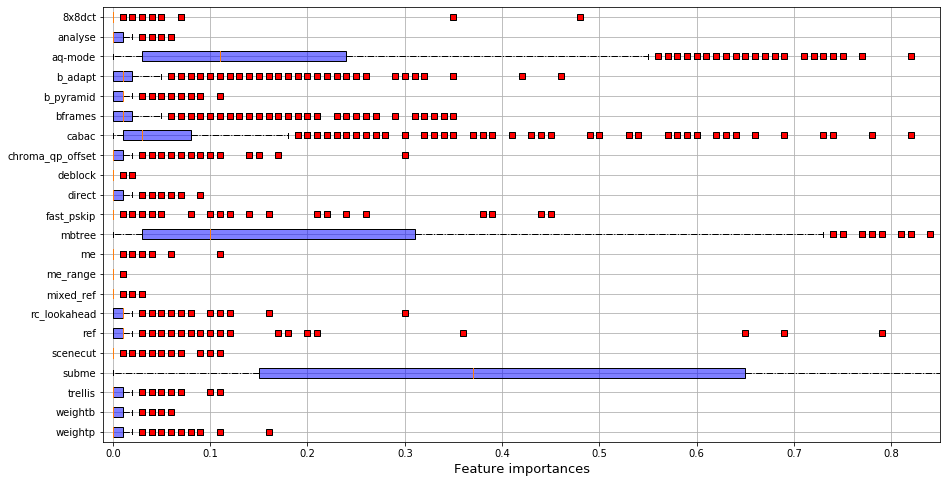

In [14]:
def boxplot_imp(res, xlim = None, criteria = 'max', name = None):
    if criteria == 'max':
        listImp = [(np.percentile(res[col],75), res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'range':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'name':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[2], reverse=True)

    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel('Feature importances',size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if name:
        plt.savefig(name)
    plt.show()
    
boxplot_imp(res, xlim = (-0.01,0.85),
            criteria = 'name', 
            name = "../../results/boxplot_features_imp_rf_"+predDimension+".png")

### Regression

In [15]:
def compute_poly(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    #listFeatures = ['subme','aq-mode','mbtree','cabac']
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    names = listFeatures
    final_names = []
    final_names.append('constant')
    for n in names:
        final_names.append(n)
    for n1 in range(len(names)):
        for n2 in range(len(names)):
            if n1>=n2:
                final_names.append(str(names[n1])+'*'+str(names[n2]))
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        clf = LinearRegression()
        X = df.drop([predDimension],axis=1)

        y = df[predDimension]
        #poly = PolynomialFeatures(degree=1, interaction_only = False, include_bias = True)    
        #X_interact = pd.DataFrame(poly.fit_transform(X))#, columns=final_names)
        #kept_names = ['subme','aq-mode','mbtree','cabac','cabac*mbtree','aq-mode*subme','cabac*subme']
        clf.fit(X,y)
        listImportances.append(clf.coef_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').drop(['open_gop','qpmax']).transpose()
    return res

res = compute_poly(listVideo)
res.to_csv("../../results/list_features_importances_poly_"+predDimension+".csv")
res

features,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,8x8dct,...,bframes,b_pyramid,b_adapt,direct,weightb,weightp,scenecut,rc_lookahead,mbtree,aq-mode
video_0,-0.18,-0.00,0.06,-0.07,-0.07,-0.03,-0.03,-0.06,-0.09,-0.01,...,-0.05,0.16,0.05,-0.02,-0.18,-0.13,-0.15,-0.01,-0.05,0.00
video_1,-0.25,-0.15,-0.04,-0.04,-0.17,-0.28,0.00,-0.04,0.04,-0.19,...,-0.09,0.07,0.04,-0.01,-0.14,-0.06,0.03,-0.01,0.13,-0.43
video_2,-0.19,0.00,-0.05,-0.03,-0.07,-0.30,-0.05,-0.03,0.03,-0.11,...,-0.07,-0.09,0.06,-0.02,-0.34,0.04,-0.04,0.05,-0.02,-0.27
video_3,-0.15,0.07,-0.09,-0.04,-0.06,-0.32,-0.01,-0.05,0.11,-0.17,...,-0.06,-0.17,0.12,-0.01,-0.33,0.03,-0.01,0.05,0.27,-0.43
video_4,-0.14,0.02,-0.05,-0.00,-0.10,-0.26,-0.01,-0.04,0.06,-0.20,...,-0.10,-0.00,0.13,-0.04,-0.33,0.01,0.01,0.03,0.11,-0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video_945,-0.16,0.05,-0.09,-0.05,-0.06,-0.33,-0.01,-0.06,0.05,-0.20,...,-0.04,-0.06,0.19,-0.02,-0.36,0.06,-0.04,0.11,-0.13,-0.29
video_946,-0.06,0.11,-0.13,-0.08,-0.05,-0.37,-0.02,-0.06,0.11,-0.21,...,-0.08,-0.05,0.08,-0.00,-0.33,0.03,0.00,0.06,0.42,-0.47
video_947,-0.14,0.07,-0.12,-0.06,-0.06,-0.41,-0.01,-0.06,0.10,-0.21,...,-0.07,-0.08,0.16,0.00,-0.31,0.02,0.00,0.05,0.09,-0.35
video_948,-0.44,0.01,-0.07,-0.05,-0.10,-0.12,-0.00,-0.02,0.10,-0.04,...,-0.07,0.12,-0.06,0.02,0.03,0.03,0.17,0.05,-0.79,0.46


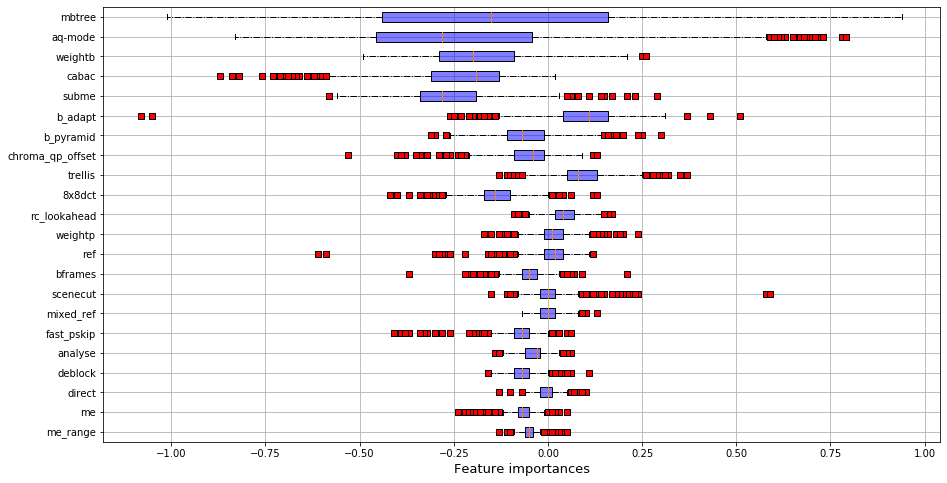

In [16]:
boxplot_imp(res, criteria ='range', name ="../../results/boxplot_features_imp_linear_"+predDimension+".png")

# RQ2

## RQ2.1 - Group of performances

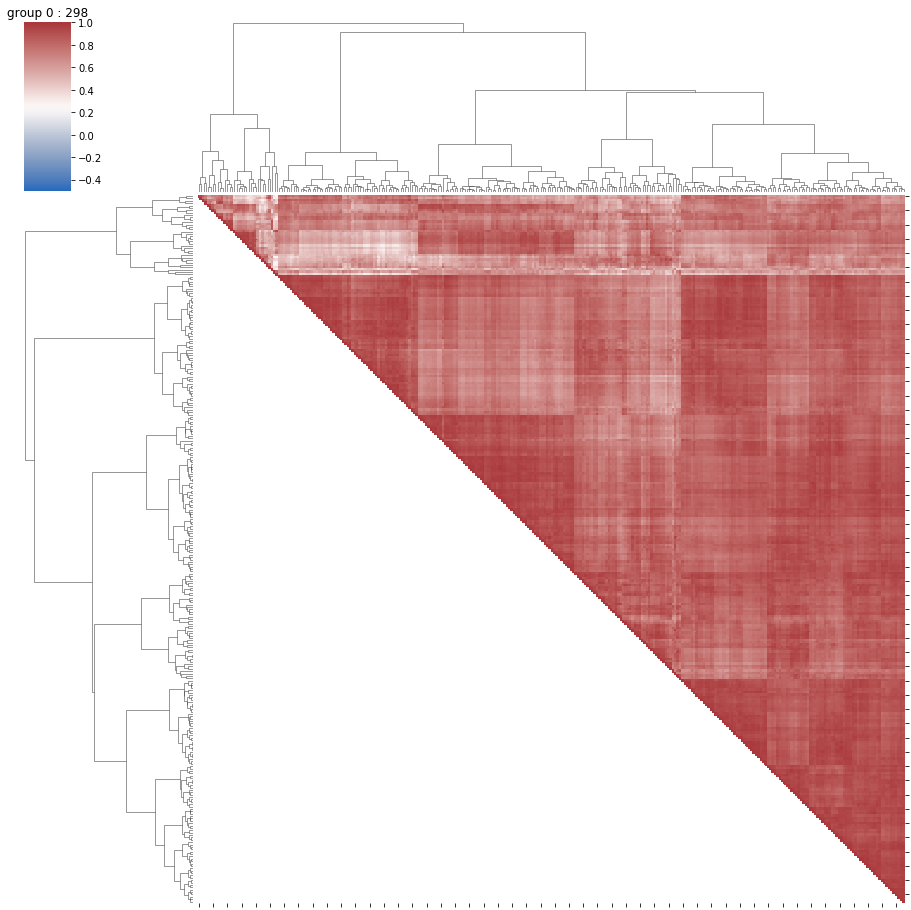

count    44253.000000
mean         0.806827
std          0.112286
min          0.150306
25%          0.742779
50%          0.828481
75%          0.893011
max          0.996081
dtype: float64


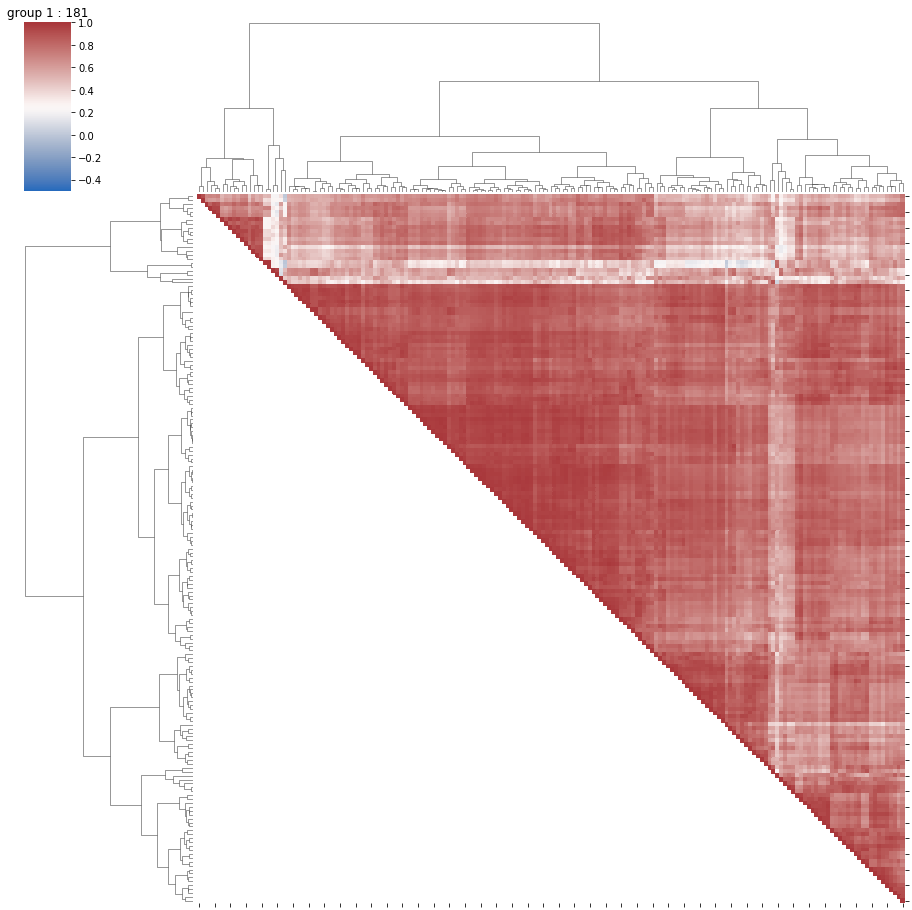

count    16290.000000
mean         0.761993
std          0.149836
min         -0.007185
25%          0.682234
50%          0.795531
75%          0.872473
max          0.997228
dtype: float64


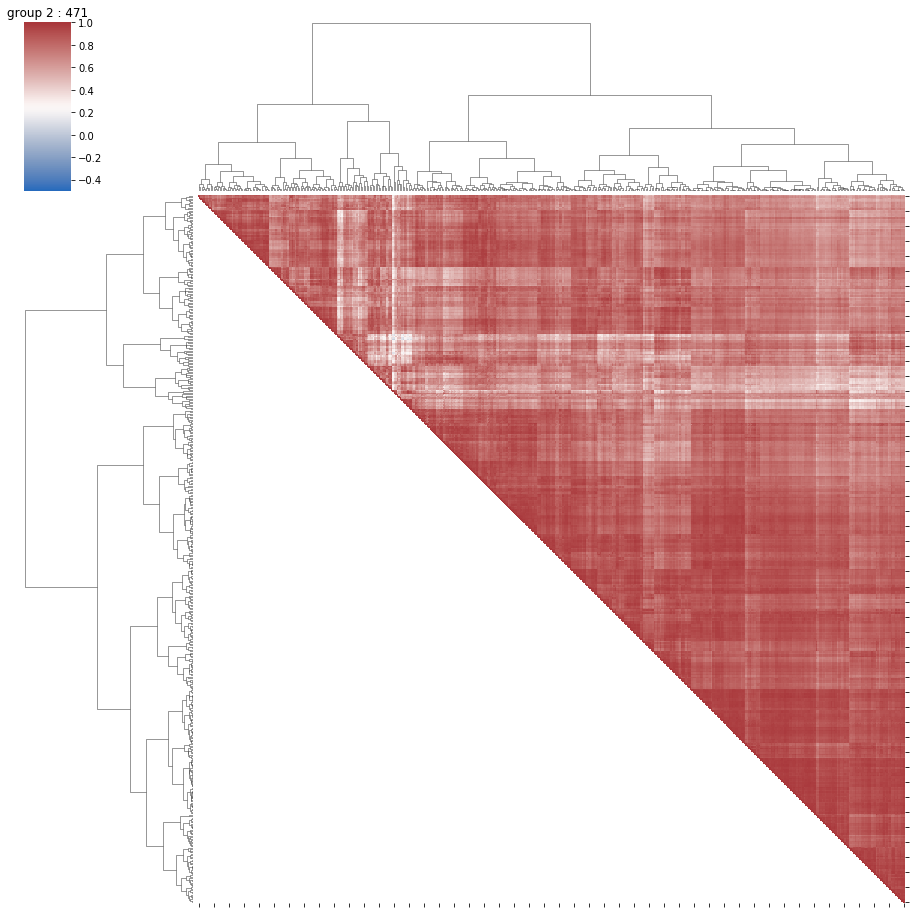

count    110685.000000
mean          0.787187
std           0.122530
min           0.044316
25%           0.712072
50%           0.806568
75%           0.883056
max           0.996812
dtype: float64


In [17]:
def plot_corr_matrix(corr, method = 'ward', title=''):

    df = pd.DataFrame(corr)
    
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i>j:
                mask[order[i]][order[j]] = True
    
    g = sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), vmin=-0.5)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    plt.title(title)
    plt.show()
    
    corrDescription = [corr[i][j] for i in range(len(corr)) for j in range(len(corr)) if i >j]
    return pd.Series(corrDescription).describe()

def plot_group(group_index):
    ind = np.array([k for k in range(len(corrSpearman)) if groups[k] == group_index], dtype=int)
    group = np.copy([[corrSpearman[k][j] for j in ind] for k in ind])
    print(plot_corr_matrix(group,title="group "+str(group_index)+" : "+str(len(group))))

for i in range(3):
    plot_group(i)

## Summary per group

In [18]:
meta = pd.read_csv("../../data/ugc_meta/all_features.csv").set_index('FILENAME')
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
del meta['NOISE_DMOS']
meta = meta.fillna(0)
cat_tab = pd.Series(meta['category'].values).unique()
meta['video_category'] = [np.where(cat_tab==meta['category'][i])[0][0] for i in range(len(meta['category']))]
del meta['category']
for col in meta.columns:#[:len(meta.columns)-1]:
    inter = np.array(meta[col],float)
    meta[col] = (inter-np.mean(inter))/np.std(inter)
perf = pd.DataFrame({'FILENAME': np.array([v_names[k][:-4] for k in range(len(v_names))])[1:],
              'perf_group' : np.array([k for k in groups])[1:]}).set_index('FILENAME')
meta_perf = perf.join(meta)
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
FILENAME,,,,,,,,,,
Animation_1080P-05f8,2,0.843640,0.742227,0.380890,0.330315,-0.147062,0.443113,2.546727,2.208462,-1.618994
Animation_1080P-0c4f,2,-0.656518,-0.377309,0.380890,0.330315,0.422696,-0.963894,1.055535,-1.232585,-1.618994
Animation_1080P-0cdf,0,-0.294941,-0.059125,0.380890,0.330315,-0.028411,0.429840,-0.102867,-0.448165,-1.618994
Animation_1080P-18f5,0,-0.479576,-0.377309,0.380890,0.330315,1.289667,-0.959469,-0.050889,0.193239,-1.618994
Animation_1080P-209f,2,6.282675,-0.377309,0.380890,0.330315,2.315231,-1.512538,-0.622865,-1.232585,-1.618994
...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,2,-0.679597,-0.377309,-0.241046,-0.334452,0.979531,-1.415198,-0.652628,0.457602,1.494285
Vlog_720P-5d08,0,-0.679597,-0.377309,-0.773579,-0.334452,3.258561,-0.304636,-0.437382,-0.157800,1.494285
Vlog_720P-60f8,0,0.443598,0.624381,-0.241046,-0.334452,0.234735,-0.043587,-0.364052,-0.149132,1.494285


In [19]:
meta_perf['str_video_cat'] = [str(meta_perf.index[i]).split('_')[0] for i in range(meta_perf.shape[0])]
total_cat = meta_perf.groupby('str_video_cat').count()['perf_group']
group_perf = np.array([gr for gr in groups])
group_perf

array([1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0,
       2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 1,
       1, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0,
       2, 2, 2, 2, 1, 0, 2, 2, 0, 1, 0, 2, 0, 1, 0, 0, 2, 0, 2, 2, 2, 2,
       1, 2, 1, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 0, 1, 0, 2, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 1,
       2, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0,
       1, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2,
       2, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0,
       1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1, 2, 1,
       1, 2, 1, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0,

In [20]:
def summary_group(id_group):
            
    id_list = [i for i in range(len(listVideo)) if group_perf[i]==id_group]
    v_names_group = [v_names[i][:-4] for i in range(len(v_names)) if i in id_list]
    listVideoGroup = [listVideo[i] for i in range(len(listVideo)) if i in id_list]
    
    print('Group '+str(id_group)+' : '+str(len(listVideoGroup))+' videos!')
    
    print('\n')

    # features importances
    boxplot_imp(compute_Importances(listVideoGroup), criteria = 'name', xlim= (0, 1),
               name ="../results/boxplot_imp_group"+str(id_group)+".png")

    # features effects
    boxplot_imp(compute_poly(listVideoGroup), criteria = 'name', xlim = (-1, 1),
               name ="../results/boxplot_effect_group"+str(id_group)+".png")

    print('\n')

    interest_var = ['cpu', 'etime', 'fps', 'kbs', 'size']

    for iv in interest_var:
        pred = [np.mean(lv[iv]) for lv in listVideoGroup]
        print('Mean '+iv+' in the group: '+str(np.round(np.mean(pred),1)))

    print('\n')

    # percentage of the videos present in the group par category

    meta_perf_group = meta_perf.query('perf_group=='+str(id_group))
    meta_perf_group['str_video_cat'] = [str(meta_perf_group.index[i]).split('_')[0] for i in range(meta_perf_group.shape[0])]
    val_group = meta_perf_group.groupby('str_video_cat').count()['perf_group']
    df_res_cat_group = pd.DataFrame({'val': val_group, 'total': total_cat})
    print(df_res_cat_group['val']/df_res_cat_group['total'])

    print('\n')

    # Mean of the videos of the group per properties

    for col in meta_perf_group.columns:
        if col not in ['str_video_cat', 'video_category']:
            print('Mean '+col+' : '+str(meta_perf_group[col].mean()))
            print('std '+col+' : '+str(meta_perf_group[col].std()))

    print('\n')

    corrGroup = np.array([corrSpearman[i][j] for i in range(len(corrSpearman)) if i in id_list 
                 for j in range(len(corrSpearman)) if j in id_list],float)

    print("Correlations intra-group: \n" + str(pd.Series(corrGroup).describe().iloc[[1,5]])+'\n')

summary_group(0)

summary_group(1)

summary_group(2)

### Inter-group correlogram

In [22]:
group_perf =groups
id_list_0 = [i for i in range(len(listVideo)) if group_perf[i]==0]
id_list_1 = [i for i in range(len(listVideo)) if group_perf[i]==1]
id_list_2 = [i for i in range(len(listVideo)) if group_perf[i]==2]

res = np.zeros(9).reshape(3,3)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res[0][1] = np.mean(tab)

for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res[0][2] = np.mean(tab)

for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res[1][2] = np.mean(tab)

print(res)

res_med = np.zeros(9).reshape(3,3)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res_med[0][1] = np.median(tab)

for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res_med[0][2] = np.median(tab)

for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res_med[1][2] = np.median(tab)

res_med

[[0.         0.07700171 0.38845099]
 [0.         0.         0.43624768]
 [0.         0.         0.        ]]


array([[0.        , 0.08604297, 0.4249381 ],
       [0.        , 0.        , 0.47670242],
       [0.        , 0.        , 0.        ]])

## Penalized regression

In [23]:
def compute_lasso_reg(listVid, id_short=None, sort_method = 'mean'):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    names = listFeatures
    final_names = []
    final_names.append('constant')
    #for n in names:
    #    final_names.append(n)
    for n1 in range(len(names)):
        for n2 in range(len(names)):
            if n1>=n2:
                final_names.append(str(names[n1])+'*'+str(names[n2]))
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]
        for col in df.columns:
            if col not in categorial:
                if col != predDimension:
                    arr_col = np.array(df[col],int)
                    arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                    df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        clf = ElasticNet(l1_ratio = 1, tol = 0.01)
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        
        poly = PolynomialFeatures(degree=2, interaction_only = True, include_bias = True)
        
        X_interact = pd.DataFrame(poly.fit_transform(X), columns=final_names)
        
        clf.fit(X_interact,y)
        
        listImportances.append(clf.coef_)

    res = pd.DataFrame({'features' : final_names})
    
    cs = 100
    
    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = listImportances[id_video]
    
    res = res.set_index('features').transpose()
    
    feats = []
    for f in res.columns:
        if sort_method == 'mean':
            feats.append(np.mean(np.abs(res[f])))
        elif sort_method == 'max_abs':
            feats.append(np.max(np.abs(res[f])))
    
    return res[pd.Series(feats, res.columns).sort_values(ascending=False)[0:25].index]

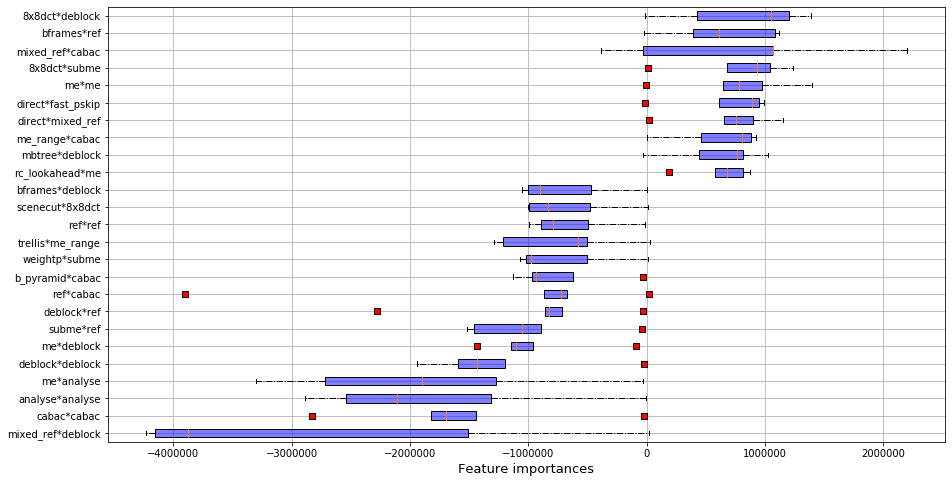

In [24]:
boxplot_imp(compute_lasso_reg(listVideo[0:5], sort_method = 'mean'))

### With dummification - Fixed values for features

In [25]:
vid = listVideo[0]

keep_features = ['cabac', 'ref', 'deblock', 'analyse', 'me', 'subme',
       'mixed_ref', 'me_range', 'trellis', '8x8dct', 'fast_pskip',
       'chroma_qp_offset', 'bframes', 'b_pyramid', 'b_adapt', 'direct',
       'weightb', 'open_gop', 'weightp', 'scenecut', 'rc_lookahead', 'mbtree',
       'qpmax', 'aq-mode']

dummies = pd.get_dummies(vid[keep_features], 
                   drop_first = False,
                   columns=keep_features)

X = pd.DataFrame(np.array(dummies, dtype=int))

poly = PolynomialFeatures(degree=2, interaction_only = True, include_bias = False)

dum_names = dummies.columns

X_interact = pd.DataFrame(np.array(poly.fit_transform(dummies),int))

names = []
for i in range(len(dum_names)):
    names.append(dum_names[i])
for i in range(len(dum_names)):
    for j in np.arange(i+1,len(dum_names), 1):
        names.append(dum_names[i] + " " + dum_names[j])

X_interact.columns = names
X_interact

,cabac_0,cabac_1,ref_1,ref_2,ref_3,ref_5,ref_7,ref_8,ref_16,deblock_0:0:0,...,mbtree_0 mbtree_1,mbtree_0 qpmax_69,mbtree_0 aq-mode_0,mbtree_0 aq-mode_1,mbtree_1 qpmax_69,mbtree_1 aq-mode_0,mbtree_1 aq-mode_1,qpmax_69 aq-mode_0,qpmax_69 aq-mode_1,aq-mode_0 aq-mode_1
0,1,0,1,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
3,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
197,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,1,0
198,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
199,1,0,0,0,1,0,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0


In [26]:
def compute_lasso(id_group):
    id_video = [i for i in range(len(listVideo)) if group_perf[i]==id_group]
    keep_inter = []
    for idv in id_video:
        vid = listVideo[idv]
        regr = ElasticNet(l1_ratio = 1, tol = 0.01)
        regr.fit(X_interact, vid[predDimension])
        serie = pd.Series(np.abs(regr.coef_), names)
        keep_inter.append(np.array(serie.sort_values(ascending=False)[0:25].index, str))
    arr = np.array(keep_inter).reshape(-1,1)
    d = dict()
    for interact in arr:
        word = interact[0]
        if word not in d:
            d[word] = 1
        else:
            d[word] = d[word]+1
    res = pd.Series([d[w] for w in d.keys()], d.keys())
    return np.array(res.sort_values(ascending=False)[0:25].index, str)  

In [27]:
for t in range(3):
    print(np.sort(compute_lasso(t)))

['analyse_0:0' 'analyse_0x3:0x3 bframes_0' 'aq-mode_0' 'cabac_0'
 'cabac_0 analyse_0x3:0x133' 'cabac_0 bframes_16' 'cabac_0 ref_1'
 'cabac_0 ref_16' 'cabac_0 ref_3' 'cabac_0 ref_5' 'cabac_0 ref_8'
 'cabac_0 subme_11' 'cabac_1 deblock_0:0:0' 'cabac_1 scenecut_None'
 'deblock_0:0:0' 'rc_lookahead_20' 'ref_1' 'ref_1 subme_11'
 'ref_16 subme_7' 'ref_2 subme_7' 'ref_3 analyse_0:0' 'scenecut_None'
 'subme_0' 'subme_2' 'subme_7']
['analyse_0:0 subme_1' 'aq-mode_0' 'bframes_0' 'cabac_0'
 'cabac_0 bframes_16' 'cabac_0 ref_1' 'cabac_0 ref_16' 'cabac_0 ref_3'
 'cabac_0 ref_5' 'cabac_0 subme_11' 'cabac_1 ref_7'
 'cabac_1 scenecut_None' 'mbtree_0' 'me_dia' 'me_hex subme_0' 'ref_1'
 'ref_2 subme_10' 'ref_3' 'ref_3 analyse_0x113:0x113' 'ref_7'
 'scenecut_None' 'subme_1 rc_lookahead_10' 'subme_2' 'subme_6' 'subme_7']
['analyse_0:0' 'analyse_0:0 subme_1' 'b_pyramid_1' 'bframes_0' 'cabac_0'
 'cabac_0 bframes_16' 'cabac_0 ref_1' 'cabac_0 ref_16' 'cabac_0 ref_3'
 'cabac_0 ref_5' 'cabac_0 ref_8' 'cabac_0 s

## Quantile regression

In [28]:
def compute_quantile_reg(listVid, id_short=None, quantile = 0.5):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]
        for col in df.columns:
            if col not in categorial:
                if col != predDimension:
                    arr_col = np.array(df[col],int)
                    arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                    df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        if quantile:
            clf = QuantileLinearRegression(quantile=quantile)
        else:
            clf = QuantileLinearRegression()
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        
        clf.fit(X,y)
        
        listImportances.append(clf.coef_)

    res = pd.DataFrame({'features' : listFeatures})
    
    cs = 100
    
    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = listImportances[id_video]
    
    return res.set_index('features').transpose()

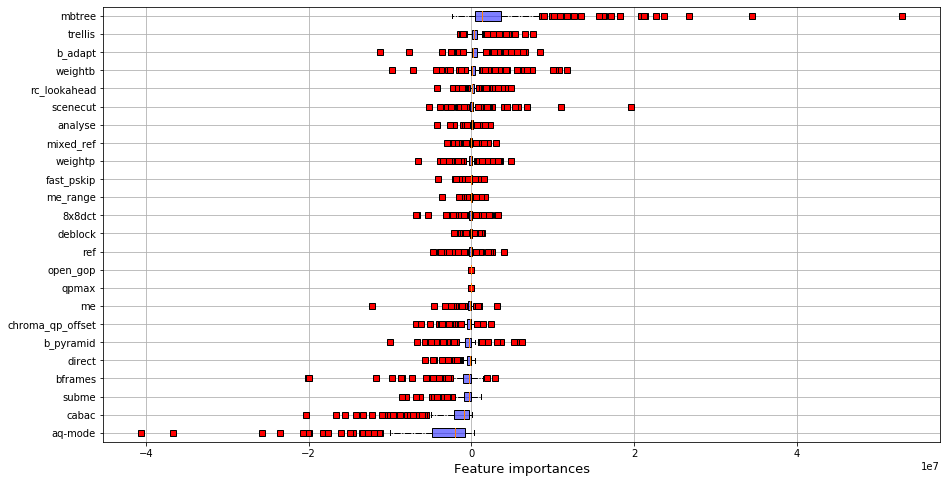

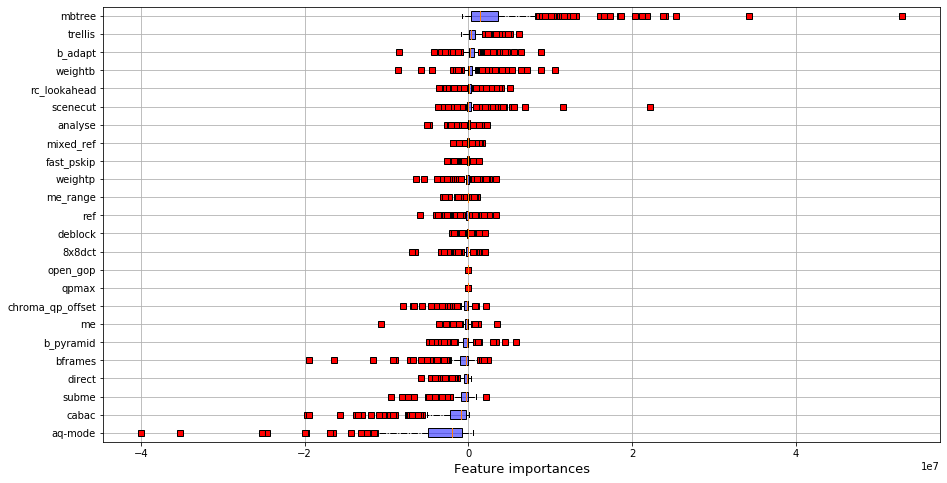

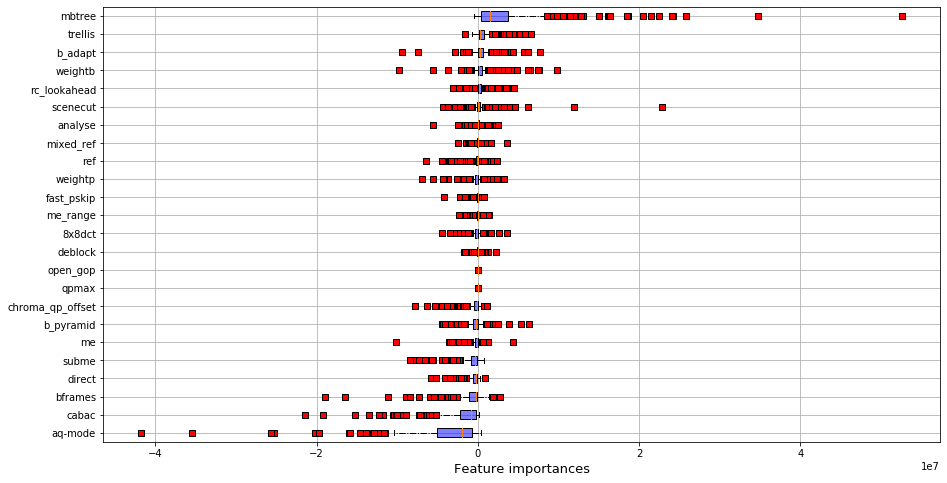

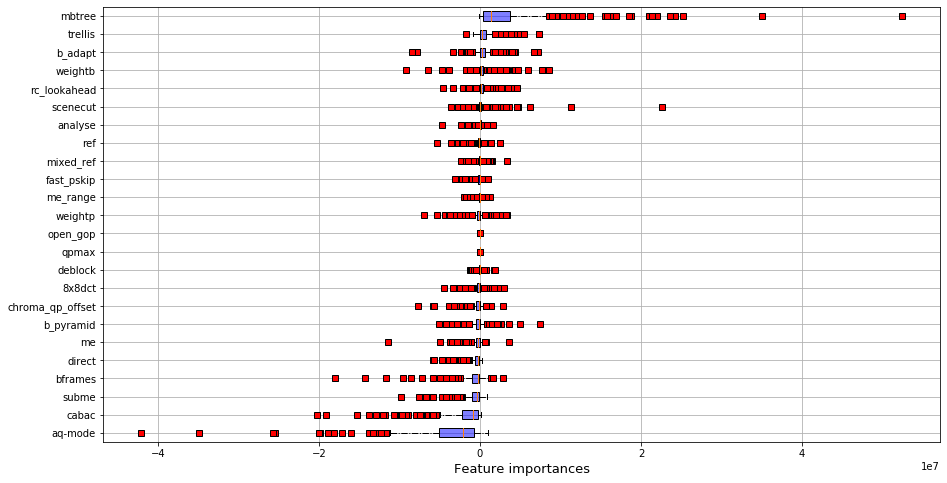

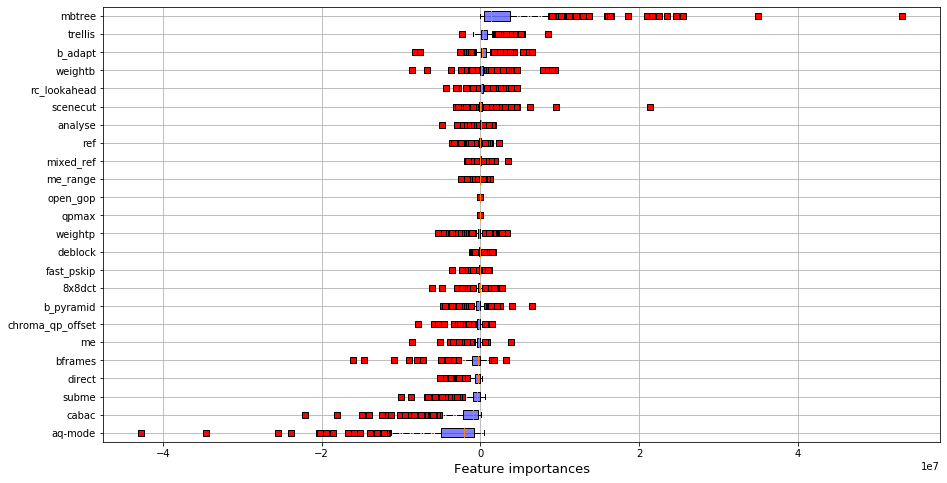

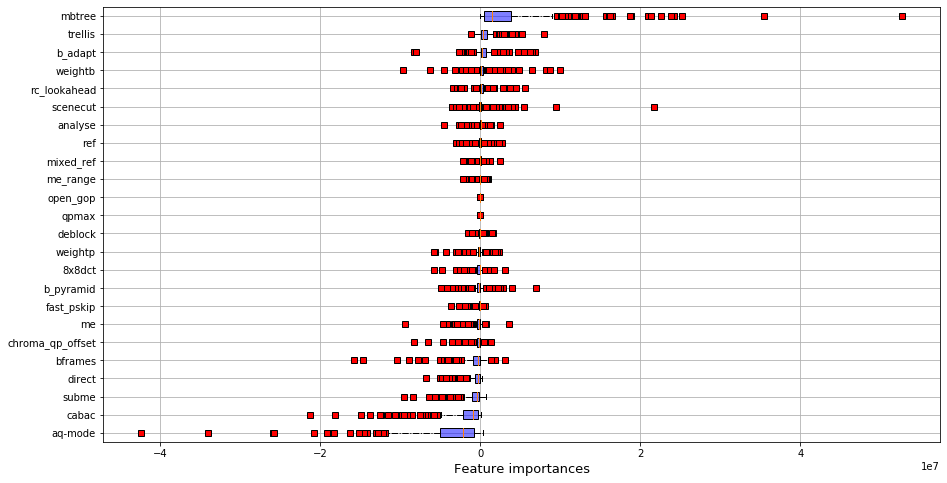

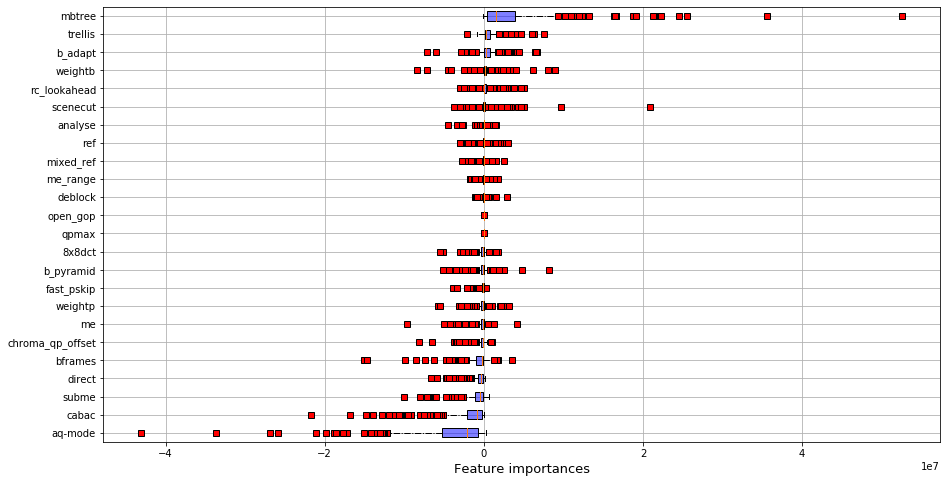

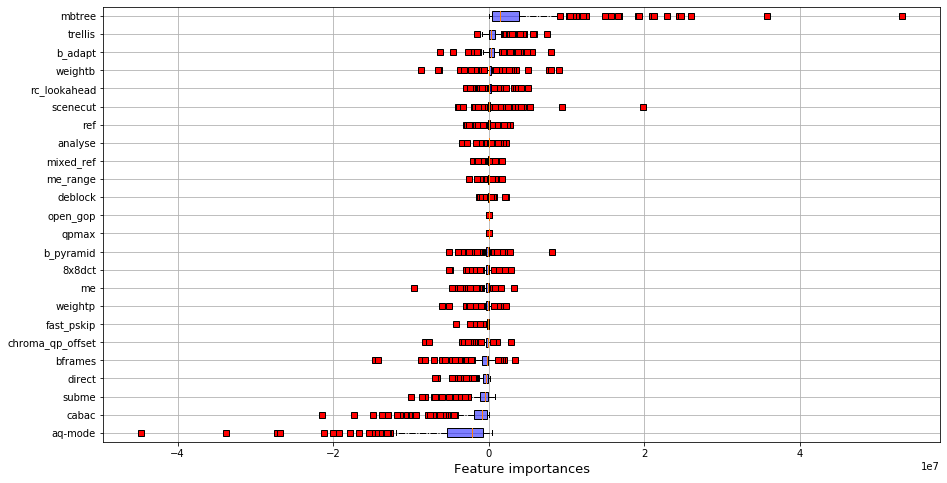

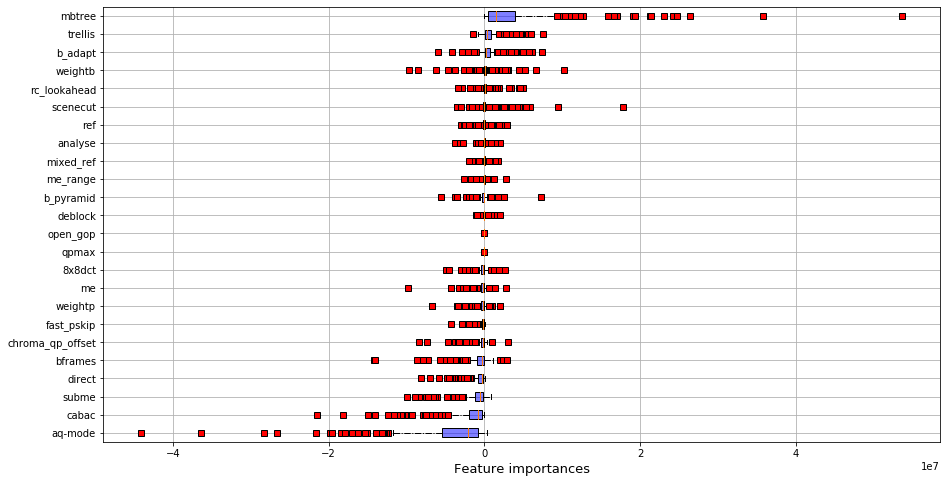

In [29]:
id_list = [i for i in range(len(listVideo)) if group_perf[i]==0]
listVideoGroup = [listVideo[i] for i in range(len(listVideo)) if i in id_list]
quantile = [0.1*k for k in np.arange(0.1,1,0.1)]
for q in quantile:
    boxplot_imp(compute_quantile_reg(listVideoGroup, quantile = q))

# PCA

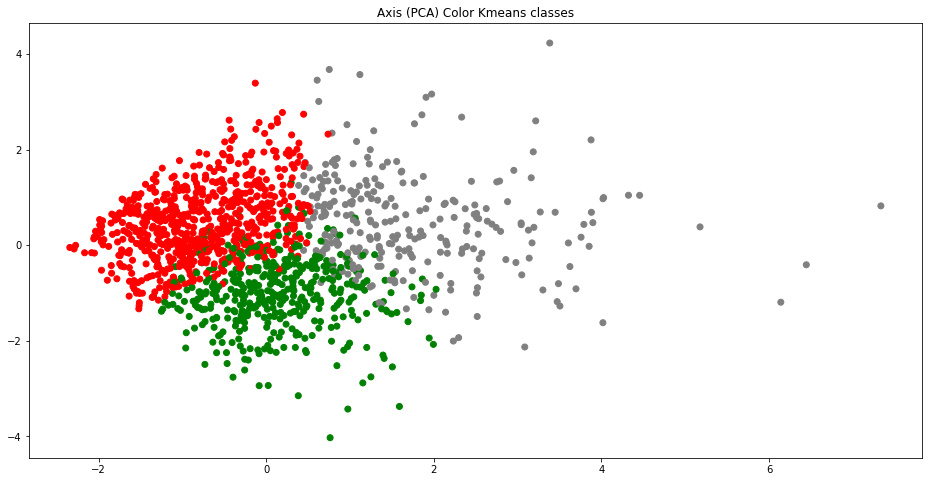

In [30]:

df_std_meta = meta[['SPATIAL_COMPLEXITY', 'TEMPORAL_COMPLEXITY', 
                          'CHUNK_COMPLEXITY_VARIATION','COLOR_COMPLEXITY']]
std_meta = np.array(df_std_meta)

kmeans = KMeans(n_clusters=3)
kmeans.fit(std_meta)
meta['clusters'] = kmeans.labels_
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
meta['quality']=[str(meta.index[i]).split('_')[1].split('-')[0] for i in range(meta.shape[0])]


pca = PCA(n_components=2, svd_solver='full')
tab = pca.fit_transform(std_meta)
x = [tab[i][0] for i in range(len(tab))]
y = [tab[i][1] for i in range(len(tab))]

col = ['gray','red','green','black']

plt.figure(figsize=(16,8))
plt.title("Axis (PCA) Color Kmeans classes")
plt.scatter(x, y, color = [col[k] for k in meta['clusters']])
lab=np.array(meta.index,str)
#for i in range(len(x)):
#    plt.text(x[i], y[i], lab[i])
plt.show()

In [31]:
pd.crosstab(meta_perf['perf_group'], meta['clusters'])

clusters,0,1,2
perf_group,,,
0,146,103,49
1,1,51,128
2,34,311,126


In [32]:
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category,str_video_cat
FILENAME,,,,,,,,,,,
Animation_1080P-05f8,2,0.843640,0.742227,0.380890,0.330315,-0.147062,0.443113,2.546727,2.208462,-1.618994,Animation
Animation_1080P-0c4f,2,-0.656518,-0.377309,0.380890,0.330315,0.422696,-0.963894,1.055535,-1.232585,-1.618994,Animation
Animation_1080P-0cdf,0,-0.294941,-0.059125,0.380890,0.330315,-0.028411,0.429840,-0.102867,-0.448165,-1.618994,Animation
Animation_1080P-18f5,0,-0.479576,-0.377309,0.380890,0.330315,1.289667,-0.959469,-0.050889,0.193239,-1.618994,Animation
Animation_1080P-209f,2,6.282675,-0.377309,0.380890,0.330315,2.315231,-1.512538,-0.622865,-1.232585,-1.618994,Animation
...,...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,2,-0.679597,-0.377309,-0.241046,-0.334452,0.979531,-1.415198,-0.652628,0.457602,1.494285,Vlog
Vlog_720P-5d08,0,-0.679597,-0.377309,-0.773579,-0.334452,3.258561,-0.304636,-0.437382,-0.157800,1.494285,Vlog
Vlog_720P-60f8,0,0.443598,0.624381,-0.241046,-0.334452,0.234735,-0.043587,-0.364052,-0.149132,1.494285,Vlog


In [35]:
pd.crosstab(meta['category'], meta['clusters'])

clusters,0,1,2
category,,,
Animation,12,48,27
CoverSong,9,46,28
Gaming,56,55,32
HDR,2,23,27
HowTo,14,60,13
Lecture,4,76,24
LiveMusic,12,34,28
LyricVideo,9,40,11
MusicVideo,23,27,28
